# An Autoencoder implementation on the Wisconsin Breast Cancer dataset
This notebook shows an implementation of an autoencoder model using the popular wisconsin breast cancer dataset.

### Import libraries

In [71]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from sklearn.feature_selection import VarianceThreshold
from keras import models
from keras import layers
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Dropout

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

check if we are using GPU or CPU

In [72]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13147071679266701494
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7845188479915073599
physical_device_desc: "device: XLA_CPU device"
]


### Import Dataset

In [26]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

Define independent variables/features and labels.

In [27]:
y = data.target
x = data.data

Perform Train-Test split

In [28]:
xtr00, xte0, ytr0, yte0 = train_test_split(pd.DataFrame(x), pd.DataFrame(y), test_size=0.2, random_state=42)
ytr = ytr0.sort_values(by = [0])
xtr0 = xtr00.reindex(ytr.index)
ytr = ytr.values
yte = yte0.values
ytr[ytr == 0] = -1
yte[yte == 0] = -1

MinMax Scaler between 0 and 1

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
xtr = pd.DataFrame(scaler.fit_transform(xtr0.values))
xte = pd.DataFrame(scaler.transform(xte0))

Implement a PCA of the training data for visualization and exploration

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(xtr)
xpca_tr = pca.transform(xtr)
xpca_te = pca.transform(xte)

No handles with labels found to put in legend.


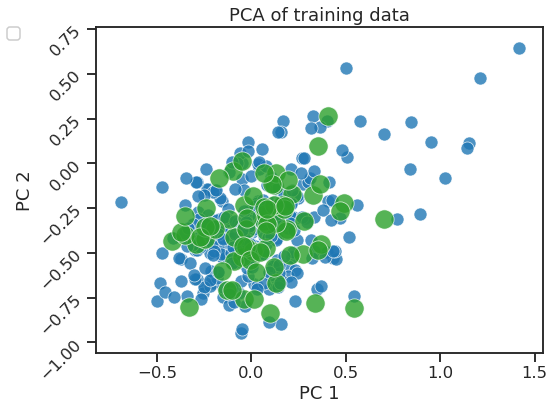

In [76]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
#sns.scatterplot(x=tsne00[:,1], y=tsne00[:,0], hue= ytr_survival.values[:,0].ravel(), alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=xpca_tr[(ytr == 1).ravel(),1], y=xpca_tr[(ytr == 1).ravel(),0], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=xpca_tr[(ytr == 0).ravel(),1], y=xpca_tr[(ytr == 0).ravel(),0],alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=xpca_te[(yte == 1).ravel(),1], y=xpca_te[(yte == 1).ravel(),0], alpha = 0.8, s= 370, legend='full')
sns.scatterplot(x=xpca_te[(yte == 0).ravel(),1], y=xpca_te[(yte == 0).ravel(),0],alpha = 0.8, s= 370, legend='full')
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.show()

### Autoencoder function
Here an autoencoder function is defined. The architecture can be changed if it is necessary.

In [77]:
def ae_arch_0(encoding_dim, epochs, bachs, l1_reg, l2_reg, lrate, xtr, xte): 
    earlstop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
    
    ################### Optimizer ###################
    optim = keras.optimizers.Adam(lr=lrate)

    ################### MODEL ARCHITECTURE ###############
    
    # 00) INPUT
    inputdim = Input(shape=(xtr.shape[1],))
    
    # 01) DENSE LAYER
    encode_i = Dense(20, kernel_regularizer=regularizers.l2(l2_reg), activation = 'relu')(inputdim)
    
    # 02) BATCH NORM
    bn_i = BatchNormalization()(encode_i)
    
    # 03) Drop Out
    # 03) DENSE LAYER
    encode_ii = Dense(10, activation = 'relu')(bn_i)

    latent = Dense(encoding_dim, kernel_regularizer = regularizers.l2(l2_reg), activation = 'relu')(encode_ii)

    # 04) DECODER
    decode_i = Dense(10, activation = 'relu')(latent)
    decode_ii = Dense(20,activation='relu')(decode_i)
    
    # 05) DECODER
    decode_iii = Dense(xtr.shape[1],activation='sigmoid')(decode_ii)
    
    # 06) AUTOENCODER
    autoencoder = Model(inputdim, decode_iii)
    encoder = Model(inputdim, latent)
    
    #encoded_input5 = Input(shape=(encoding_dim5,))
    #decoder_layer5 = autoencoder5.layers[-3]
    #decoder5 = Model(x3, decoder_layer5(x3))

    autoencoder.summary()
    compression_factor = float(np.shape(xtr)[1]) / encoding_dim
    print("Compression factor: %s" % compression_factor)
    
    ################## COMPILE AND FIT MODEL #############
    autoencoder.compile(optimizer=optim, loss='binary_crossentropy')
    autoencoder.fit(xtr, xtr,epochs=epochs, batch_size=bachs,  shuffle=True,  validation_data=(xte, xte), callbacks = [earlstop, rlrop])
    
    histval = autoencoder.history.history['val_loss']
    histtra = autoencoder.history.history['loss']
    
    return encoder, histtra, histval

Train an autoencoder model. Store the encoder function and the training loss scores.

In [78]:
encoder_val, histtra_val, histval_val = ae_arch_0(5,50,32,0, 0.0005, 0.001, xtr, xte)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 20)                620       
_________________________________________________________________
batch_normalization_6 (Batch (None, 20)                80        
_________________________________________________________________
dense_36 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_38 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_39 (Dense)             (None, 20)                220

Plot the training and validation Loss.

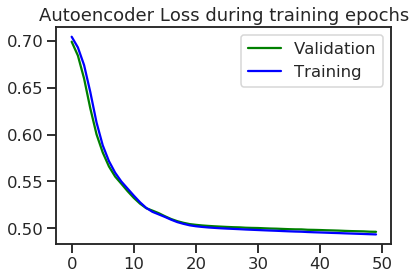

In [82]:
plt.plot(histval, c = 'g', label = "Validation")
plt.plot(histtra, c = 'b', label = "Training")
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.show()

Encode training and validation samples by using the Encoder function to obtain its projection on the latent space.

In [83]:
xlat_tr = encoder_val.predict(xtr)
xlat_te = encoder_val.predict(xte)

Visualize the training samples by class (1 or -1) in the latent space.

In [84]:
from sklearn.manifold import TSNE
xaetr_tsne = TSNE(n_components=2).fit_transform(xlat_tr)

No handles with labels found to put in legend.


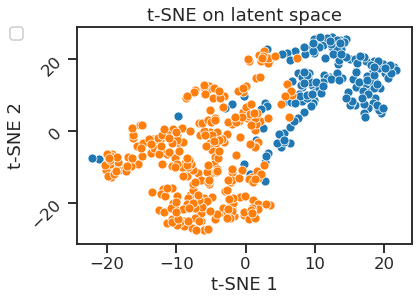

In [85]:
ax2 = plt.subplot()
sns.scatterplot(x = xaetr_tsne[(ytr).ravel() == -1,0], y = xaetr_tsne[ytr.ravel() == -1,1])
sns.scatterplot(x = xaetr_tsne[ytr.ravel() == 1,0], y = xaetr_tsne[ytr.ravel() == 1,1])
ax2.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.figure.set_size_inches( (6,4) )
ax2.set_title("t-SNE on latent space")
plt.yticks(rotation=45) 
plt.show()

In [87]:
print("The initial dimension is = " +str(np.shape(xtr)[1]) + " and the obtained latent dimension = " + str(np.shape(xlat_tr)[1]))

The initial dimension is = 30 and the obtained latent dimension = 5


We applied a 6-times compression and obtained a 5 dimensional latent space where our input samples are represented.